In [1]:
import torch
import torchvision
import torch.nn as nn
from torch import optim
from torchvision import transforms, datasets, models
from torch.utils.data import Dataset, DataLoader

from skimage import io

import os

from PIL import Image
import numpy as np
from numpy.random import default_rng
import pandas as pd
import matplotlib.pyplot as plt
import copy
import time

import warnings
warnings.filterwarnings('ignore')

plt.ion()

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


# NOTE**
80 normal and 58 tubeculosis

# Mount to Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Declare File Paths

In [4]:
work_dir =  '/content/drive/MyDrive/MontgomerySet/'
xray_pic_dir = os.path.join(work_dir, 'CXR_png/')
right_mask_dir = os.path.join(work_dir, 'ManualMask/rightMask/')
left_mask_dir = os.path.join(work_dir, 'ManualMask/leftMask')
clinical_readings_dir = os.path.join(work_dir, 'ClinicalReadings')

# Try Loading Data

### Pre-Dataset Classes

In [ ]:
class TubeImageDataset(Dataset):   # Tube is tubeculosis

    @staticmethod
    def make_imgname_df(root_dir):
        df = pd.DataFrame({'img_name': []})
        valid_file_type = ('png')
        for base, dirs, files in os.walk(root_dir):
            for file_name in files:
                file_type = file_name.split('.')[-1]
                if file_type  in valid_file_type:
                    df = df.append({'img_name': file_name}, ignore_index=True)

        return df

    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_df = self.make_imgname_df(root_dir)

    def __len__(self):
        return len(self.image_df)

    def __getitem__(self, idx):
        img_name = self.image_df.iloc[idx]['img_name']
        img_path = os.path.join(self.root_dir, img_name)
        image = io.imread(img_path, as_gray=True)
        label = img_name[12]
        
        if self.transform:
            image = self.transform(image)
        
        sample = {'image': image, 'label': label}

        return sample

In [ ]:
class CRDataset:  # Clinical Readings Dataset

    @staticmethod
    def map_data(lines):
        mapped_value = dict()
        sex_line = lines[0]
        age_line = lines[1]
        result = lines[2]
        sex = sex_line.split(': ')[-1].replace('\n', '').replace(' ', '')
        age = age_line.split(': ')[-1].replace('\n', '').replace(' ', '')
        result = result.replace('\n', '')
        age = int(age[:-1])
        mapped_value['sex'] = sex
        mapped_value['age'] = age
        mapped_value['result'] = result
        return mapped_value

    @staticmethod
    def make_df(root_dir):
        df = pd.DataFrame()
        read_mode = 'r' # read only
        for base, dirs, files in os.walk(root_dir):
            for file_name in files:
                file_path = os.path.join(root_dir, file_name)

                with open(file_path, read_mode) as f:
                    lines = f.readlines()

                new_data = CRDataset.map_data(lines)
                new_data['case_name'] = file_name.split('.')[0]
                df = df.append(new_data, ignore_index=True)

        df = df.sort_values(by=['case_name'], ignore_index=True)
        return df

    def __init__(self, root_dir, transform=None):
        self.transform = transform   # transform should be custom one
        self.df = CRDataset.make_df(root_dir)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        sample_df = self.df.iloc[idx]
        print(sample_df['result'])
        sample = {'age': sample_df['age'], 'sex': sample_df['sex'], 'result': 0 if sample_df['result'] == 'normal' else 1}
        
        if self.transform:
            transform(sample)

        return sample

In [ ]:
xray_img_dataset = TubeImageDataset(xray_pic_dir)
left_mask_img_dataset = TubeImageDataset(left_mask_dir)
right_mask_img_dataset = TubeImageDataset(right_mask_dir)

In [ ]:
cr_dataset = CRDataset(clinical_readings_dir)

# EDA

In [ ]:
print(f'Count Xray Image Dataset: {len(xray_img_dataset)}')
print(f'Count Left Mask Image Dataset: {len(left_mask_img_dataset)}')
print(f'Count Right Mask Image Dataset: {len(right_mask_img_dataset)}')
print(f'Count Clinical Readings Datast: {len(cr_dataset)}')

Count Xray Image Dataset: 138
Count Left Mask Image Dataset: 138
Count Right Mask Image Dataset: 138
Count Clinical Readings Datast: 138


In [ ]:
df = cr_dataset.df  # pass by reference

In [ ]:
df.head()

,age,case_name,result,sex
0,27.0,MCUCXR_0001_0,normal,F
1,40.0,MCUCXR_0002_0,normal,F
2,21.0,MCUCXR_0003_0,normal,F
3,11.0,MCUCXR_0004_0,normal,F
4,33.0,MCUCXR_0005_0,normal,M


In [ ]:
df.tail()

,age,case_name,result,sex
133,14.0,MCUCXR_0383_1,calcified granuloma LUL behind 4th rib anterior,F
134,42.0,MCUCXR_0387_1,inactive scars RUL,M
135,52.0,MCUCXR_0390_1,Rt apical scarring. LUL scars and some infiltr...,M
136,30.0,MCUCXR_0393_1,left pleural effusion; best seen on lateral vi...,F
137,63.0,MCUCXR_0399_1,large infiltrate RUL with cavitation plus infi...,F


In [ ]:
def get_k_intervals(min_v, max_v, k):
    step = (max_v - min_v) / k
    return ([step*i + min_v for i in range(k)], [step*(i+1) + min_v for i in range(k)])

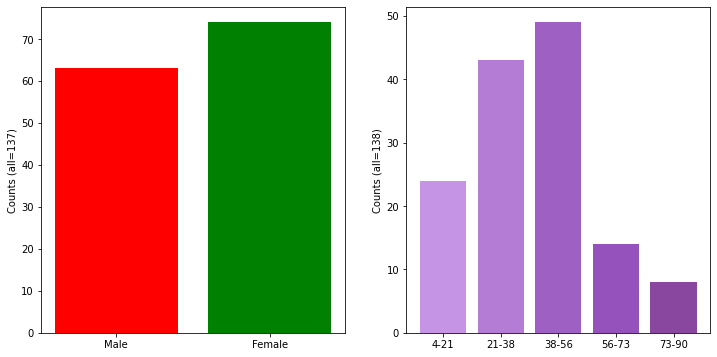

In [ ]:
fig, (sex_ax, age_ax) = plt.subplots(1, 2, figsize=(12, 6))

### show sex data ### 

sex_df = df['sex']
n_male, n_female = sex_df[sex_df == 'M'].count(), sex_df[sex_df == 'F'].count()
sex_heights = [n_male, n_female]
sex_bars = ['Male', 'Female']

sex_ypos = np.arange(len(sex_bars))
sex_ax.bar(sex_ypos, sex_heights, color=['red', 'green'])
sex_ax.set_xticks(sex_ypos)
sex_ax.set_xticklabels(sex_bars)
sex_ax.set_ylabel(f'Counts (all={sum(sex_heights)})')

### show age data ###

age_df = df['age']
n_interval = 5
min_v, max_v = age_df.min(), age_df.max()
lbound, ubound = get_k_intervals(min_v, max_v+1, n_interval)
age_heights = list()
for lb, ub in zip(lbound, ubound):
    interval_count = age_df[(age_df >= lb) & (age_df < ub)].count()
    age_heights.append(interval_count)
age_bars = [f'{lbound[i]:.0f}-{ubound[i]:.0f}' for i in range(len(lbound))]

age_color = np.array([(198, 148, 228),
             (180, 124, 212),
             (159, 96, 196),
             (149, 81, 188),
             (138, 71, 159)]) / 255

age_ypos = np.arange(len(age_bars))
age_ax.bar(age_ypos, age_heights, color=age_color)
age_ax.set_xticks(age_ypos)
age_ax.set_xticklabels(age_bars)
age_ax.set_ylabel(f'Counts (all={sum(age_heights)})')

fig.show()

In [ ]:
df[df['sex'] =='O']  ## outlier

,age,case_name,result,sex
59,5.0,MCUCXR_0080_0,normal,O


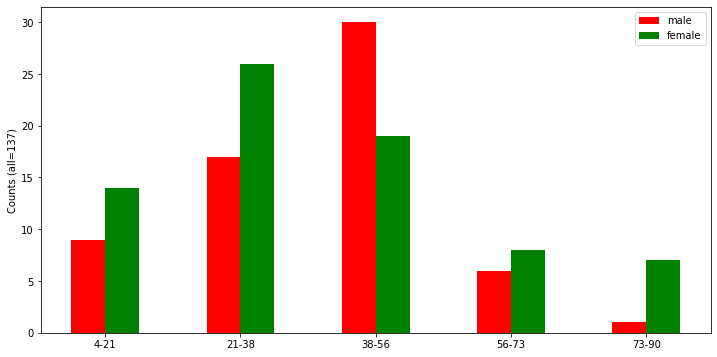

In [ ]:
### show age by gender ###
age_df = df['age']
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
male_age_df, female_age_df = df[df['sex'] == 'M']['age'], df[df['sex'] == 'F']['age']

n_interval = 5
min_v, max_v = age_df.min(), age_df.max()
lbound, ubound = get_k_intervals(min_v, max_v+1, n_interval)
age_bars = [f'{lbound[i]:.0f}-{ubound[i]:.0f}' for i in range(len(lbound))]
width = 0.25

# male data here
male_age_heights = list()
for lb, ub in zip(lbound, ubound):
    interval_count = male_age_df[(age_df >= lb) & (age_df < ub)].count()
    male_age_heights.append(interval_count)
male_age_color = ['red']*len(male_age_heights)
male_age_ypos = np.arange(len(male_age_heights))

ax.bar(male_age_ypos, male_age_heights, color=male_age_color, width=width)

# female data here
female_age_heights = list()
for lb, ub in zip(lbound, ubound):
    interval_count = female_age_df[(age_df >= lb) & (age_df < ub)].count()
    female_age_heights.append(interval_count)
female_age_color = ['green']*len(female_age_heights)
female_age_ypos = np.arange(len(female_age_heights)) + width
ax.bar(female_age_ypos, female_age_heights, color=female_age_color, width=width)

# misc
center_ypos = (male_age_ypos + female_age_ypos) / 2
ax.set_xticks(center_ypos)
ax.set_xticklabels(age_bars)
ax.set_ylabel(f'Counts (all={sum(male_age_heights) + sum(female_age_heights)})')
ax.legend(['male', 'female'])
fig.show()

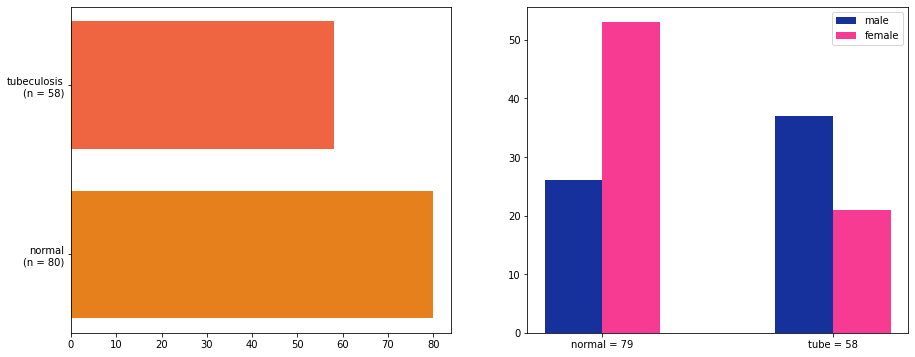

In [ ]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(15, 6))

result_df = df['result']
n_normal, n_tube = result_df[result_df == 'normal'].count(), result_df[result_df != 'normal'].count()
result_ypos = np.arange(2)
color = np.array([(230, 128, 28),
                  (239, 101, 66)]) / 255
ax1.barh(result_ypos, [n_normal, n_tube], height=0.75, color=color)
ax1.set_yticks(result_ypos)
ax1.set_yticklabels([f'normal\n(n = {n_normal})', f'tubeculosis\n(n = {n_tube})'])

male_df, female_df = df[df['sex'] == 'M'], df[df['sex'] == 'F']
male_heights = [male_df[male_df['result'] == 'normal']['result'].count(), male_df[male_df['result'] != 'normal']['result'].count()]
female_heights = [female_df[female_df['result'] == 'normal']['result'].count(), female_df[female_df['result'] != 'normal']['result'].count()]
male_color = np.array(2*[(22, 49, 156)]) / 255
female_color = np.array(2*[(247, 59, 147)]) / 255

width = 0.25
result_by_gender_ypos = np.arange(len(male_heights)) - width / 2
ax2.bar(result_by_gender_ypos, male_heights, color=male_color, width=width)
ax2.bar(result_by_gender_ypos+width, female_heights, color=female_color, width=width)

ax2.set_xticks(result_by_gender_ypos + width / 2)
ax2.set_xticklabels([f'normal = {male_heights[0]+female_heights[0]}', f'tube = {male_heights[1]+female_heights[1]}'])
ax2.legend(['male', 'female'])

fig.show()

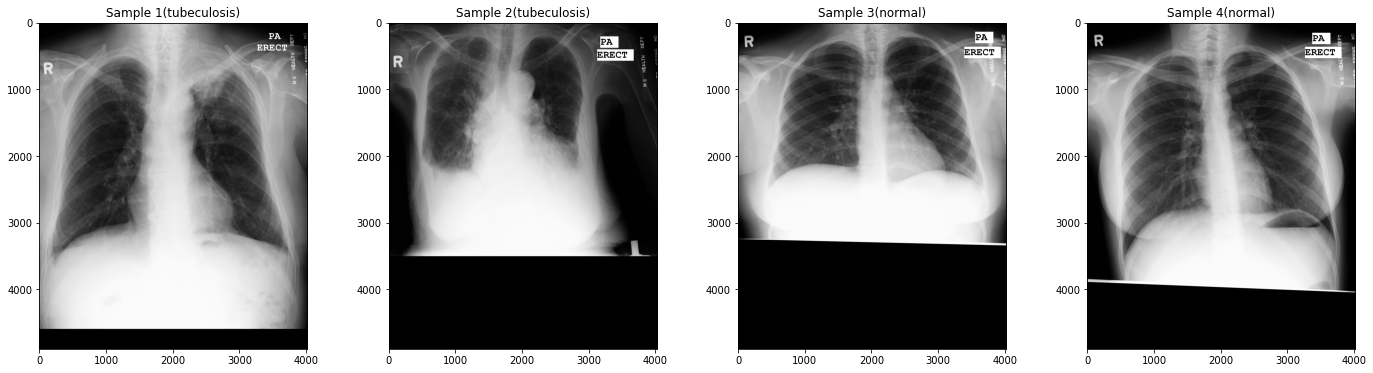

In [ ]:
## random show some data ##
from numpy.random import default_rng

show_width, show_height = 4, 1

rng = default_rng()
rand_idx_list = rng.choice(len(df), show_width*show_height, replace=False)

fig, axs = plt.subplots(show_height, show_width, figsize=(6*show_width, 6*show_height))
for i, idx in enumerate(rand_idx_list):
    xray_img = io.imread(os.path.join(xray_pic_dir, df['case_name'][idx] + '.png'), as_gray=True)
    axs[i].imshow(xray_img, cmap='gray')
    axs[i].set_title(f'Sample {i+1}({"normal" if df["result"][idx] == "normal" else "tubeculosis"})')

fig.show()

# Dataset

In [16]:
class TubeDataset(Dataset):

    def map_data(self, lines):
        mapped_value = dict()
        sex_line = lines[0]
        age_line = lines[1]
        result = lines[2]
        sex = sex_line.split(': ')[-1].replace('\n', '').replace(' ', '')
        age = age_line.split(': ')[-1].replace('\n', '').replace(' ', '')
        result = result.replace('\n', '')
        age = int(age[:-1])
        mapped_value['sex'] = sex
        mapped_value['age'] = age
        mapped_value['result'] = result
        return mapped_value

    def make_df(self, root_dir):
        df = pd.DataFrame({'img_name': []})
        valid_file_type = ('txt')
        read_mode = 'r'
        for base, dirs, files in os.walk(root_dir):
            for file_name in files:
                file_type = file_name.split('.')[-1]
                if file_type  in valid_file_type:
                    file_path = os.path.join(root_dir, file_name)

                    with open(file_path, read_mode) as f:
                        lines = f.readlines()

                    new_data = self.map_data(lines)
                    new_data['case_name'] = file_name.split('.')[0]
                    df = df.append(new_data, ignore_index=True)

        df = df.sort_values(by=['case_name'], ignore_index=True)
        return df

    def __init__(self, doc_dir, img_dirs, transforms=None):
        self.df = self.make_df(doc_dir)
        self.transforms = transforms
        self.img_dirs = img_dirs

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        sample = dict()
        case_name = self.df['case_name'][idx]
        image_type = 'png'  # magic string
        image_list = list()
        for i, img_dir in enumerate(self.img_dirs):
            img_path = os.path.join(img_dir, case_name + '.' + image_type)
            img = Image.fromarray(io.imread(img_path))
            if self.transforms:
                img = self.transforms[i].__call__(img)
            image_list.append(img)
        
        result = self.df['result'][idx]
        label = 0 if result == 'normal' else 1
        sample['images'] = image_list
        sample['label'] = label
        return sample

In [6]:
tube_dataset = TubeDataset(clinical_readings_dir, [xray_pic_dir, left_mask_dir, right_mask_dir])

## show some sample without transform

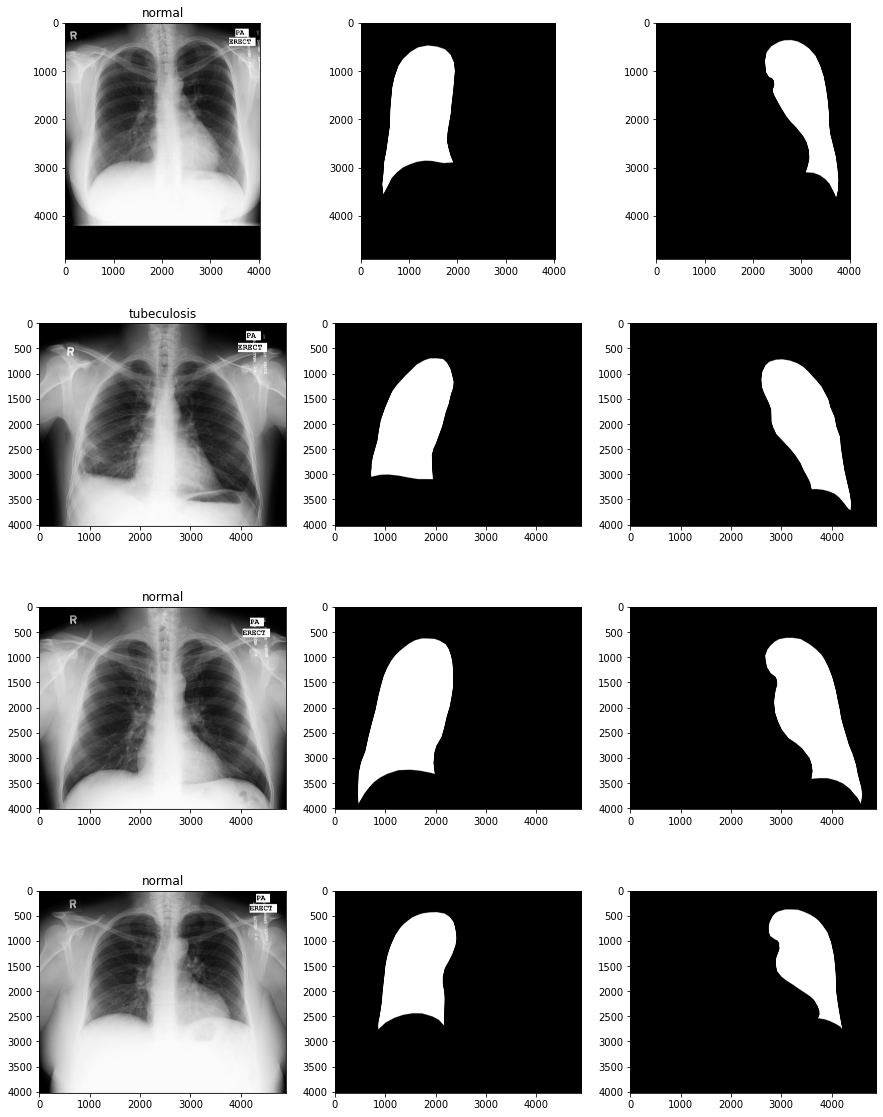

In [7]:
n_show = 4

rng = default_rng()
rand_idx_list = rng.choice(len(tube_dataset), n_show, replace=False)

fig, axs = plt.subplots(n_show, 3, figsize=(5*3, 5*n_show))
for i, idx in enumerate(rand_idx_list):
    sample = tube_dataset[idx]
    result = 'normal' if sample['label'] == '0' else 'tubeculosis'
    axs[i][0].set_title(result)
    for j, img in enumerate(sample['images']):
        axs[i][j].imshow(img, cmap='gray')
    
fig.show()

# Transformer and Custom Transformer

## implement our custom transformer

In [10]:
class LeftLungCrop(object):

    def __init__(self, crop_size):
        self.crop_size = crop_size

    def __call__(self, pil_img):
        w, h = pil_img.size
        dh = (h-self.crop_size)//2
        return pil_img.crop((0, dh, self.crop_size, dh+self.crop_size))

class RightLungCrop(object):

    def __init__(self, crop_size):
        self.crop_size = crop_size

    def __call__(self, pil_img):
        w, h = pil_img.size
        dh = (h-self.crop_size)//2
        return pil_img.crop((w-self.crop_size, dh, w, dh+self.crop_size))

## compose our and existing transformer

In [11]:
train_xray_img_transform = transforms.Compose([
    transforms.Resize((250, 250), interpolation=Image.NEAREST),
    transforms.RandomResizedCrop(220),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])
train_left_lung_img_transform = transforms.Compose([
    transforms.Resize(250),
    LeftLungCrop(220),  # custom transformer
    transforms.ToTensor()
])
train_right_lung_img_transform = transforms.Compose([
    transforms.Resize(250),
    RightLungCrop(220),  # custom transformer
    transforms.ToTensor()
])

train_transforms = [train_xray_img_transform,
                   train_left_lung_img_transform,
                   train_right_lung_img_transform]

In [12]:
tube_dataset.transforms = train_transforms

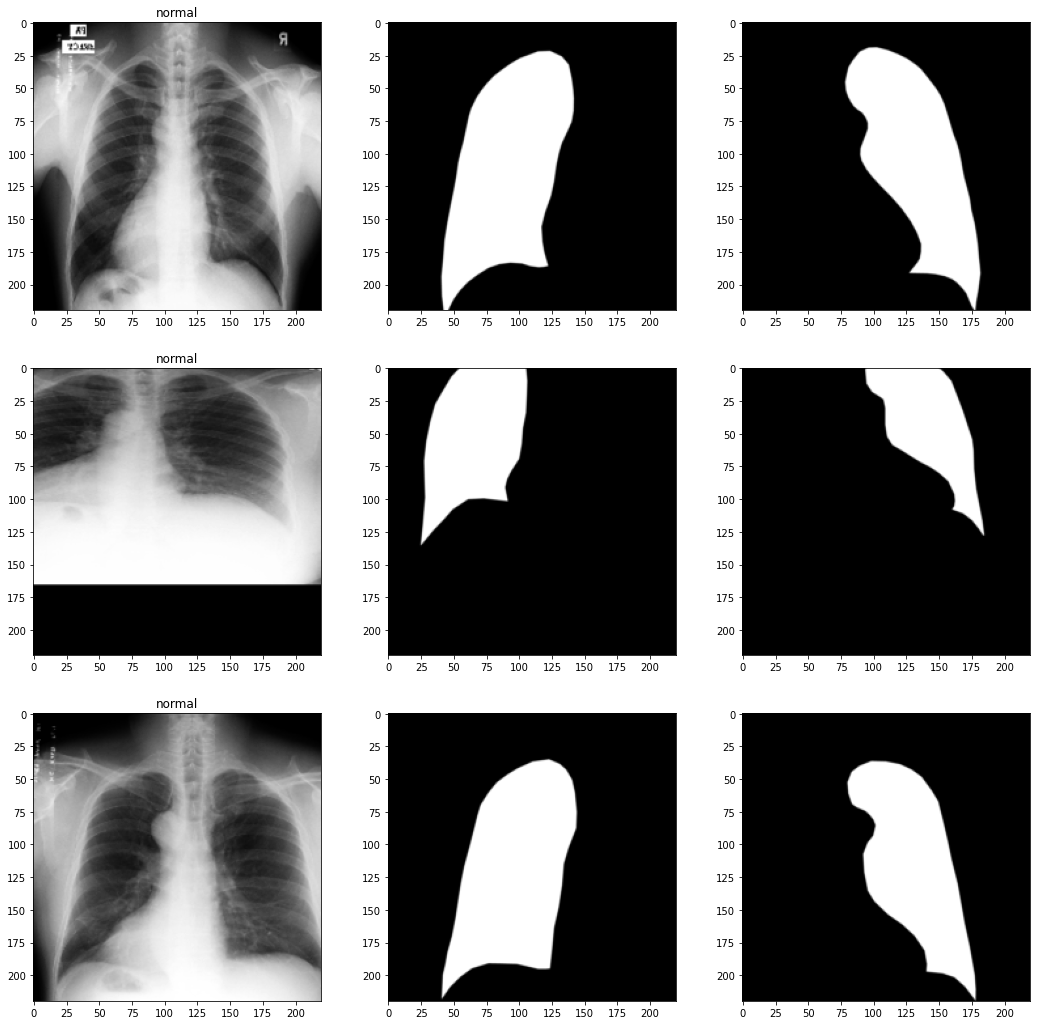

In [13]:
n_show = 3

rng = default_rng()
rand_idx_list = rng.choice(len(tube_dataset), n_show, replace=False)

fig, axs = plt.subplots(n_show, 3, figsize=(6*3, 6*n_show))
for i, idx in enumerate(rand_idx_list):
    sample = tube_dataset[idx]
    result = 'normal' if sample['label'] == '0' else 'tubeculosis'
    axs[i][0].set_title(result)
    for j, img in enumerate(sample['images']):
        axs[i][j].imshow(img[0], cmap='gray')
    
fig.show()

# Training

## Training Func

In [14]:
def train(model, criterion, optimizer, scheduler, num_epoch):

    since = time.time()

    model.train()
    for batch in train_dataloader:
        inputs = batch['images']
        labels = batch['label']
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        with torch.set_grad_enabled(True):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
    

## Try ResNet101


In [ ]:
demo_model = models.resnet101